In [1]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr, pearsonr
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [2]:
### 시각화를 위한 라이브러리
# - 파이썬 시각화에서 가장 기본적인 시각화 라이브러리
import matplotlib.pyplot as plt

### 한글처리
from matplotlib import font_manager, rc


### 운영체제 확인 라이브러리
import platform

### 시각화 시 마이너스(-, 음수) 기호 깨짐 방지
plt.rcParams["axes.unicode_minus"] = False

### OS별 한글처리
# - 윈도우 운영체게
if platform.system() == "Windows" :
    # path = "c:/Windows/Fonts/malgun.ttf"
    # font_name = font_manager.FontProperties(fname=path).get_name()
    # rc("font", family = font_name)
    
    ### 또는 아래처럼 한줄로도 가능 (아래 한글처리를 주로 사용합니다.)
    plt.rc("font", family = "Malgun Gothic")

# - Mac 운영체제
elif platform.system() == "Darwin" :
    rc("font", family = "AppleGothic")
    
else :
    print("넌 누구?")

### 데이터 불러오기 및 전처리

In [3]:
labeled = pd.read_csv('./data/labeled_data.csv')

In [4]:
labeled_cn7 = labeled[(labeled["PART_NAME"] == "CN7 W/S SIDE MLD'G RH") |(labeled["PART_NAME"] == "CN7 W/S SIDE MLD'G LH")]

In [5]:
labeled_cn7 = labeled_cn7.drop(columns=["_id", "TimeStamp","PART_FACT_PLAN_DATE", "Reason", "PART_FACT_SERIAL", "PART_NAME",
               "EQUIP_NAME", "EQUIP_CD", "Switch_Over_Position", "Mold_Temperature_1","Mold_Temperature_2","Mold_Temperature_5",
                "Mold_Temperature_6", "Mold_Temperature_7","Mold_Temperature_8","Mold_Temperature_9","Mold_Temperature_10",
               "Mold_Temperature_11","Mold_Temperature_12","Barrel_Temperature_7"])

In [6]:
labeled_cn7["PassOrFail"] = labeled_cn7["PassOrFail"].replace('Y',1).replace('N',0)

C:\Users\Admin\AppData\Local\Temp\ipykernel_8896\3829480872.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  labeled_cn7["PassOrFail"] = labeled_cn7["PassOrFail"].replace('Y',1).replace('N',0)


In [7]:
### Clamp_Open_Position에서 눈에띄게 낮은 값들 제거
cn7 = labeled_cn7[labeled_cn7["Clamp_Open_Position"]>=200] 
cn7 = cn7.drop(columns=["Clamp_Open_Position"])

In [8]:
def remove_outliers(df, column):
    # 1사분위수(Q1)와 3사분위수(Q3) 계산
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    
    # IQR 계산
    IQR = Q3 - Q1
    
    # 이상치 범위 설정
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # 이상치 제거
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    return filtered_df

In [9]:
cn7_Y = cn7[cn7["PassOrFail"]==1].copy()
print("CN7의 양품 개수:", len(cn7_Y))
cn7_N = cn7[cn7["PassOrFail"]==0].copy()
print("CN7의 불량 개수:", len(cn7_N))

CN7의 양품 개수: 6661
CN7의 불량 개수: 39


In [10]:
tmp1 = cn7_Y.copy()
tmp1 = remove_outliers(tmp1, "Injection_Time")
tmp1 = remove_outliers(tmp1, "Plasticizing_Time")
tmp1 = remove_outliers(tmp1, "Cycle_Time")
cn7_pass_removed = tmp1.copy()
cn7_pass_removed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6597 entries, 0 to 7995
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   PassOrFail                6597 non-null   int64  
 1   Injection_Time            6597 non-null   float64
 2   Filling_Time              6597 non-null   float64
 3   Plasticizing_Time         6597 non-null   float64
 4   Cycle_Time                6597 non-null   float64
 5   Clamp_Close_Time          6597 non-null   float64
 6   Cushion_Position          6597 non-null   float64
 7   Plasticizing_Position     6597 non-null   float64
 8   Max_Injection_Speed       6597 non-null   float64
 9   Max_Screw_RPM             6597 non-null   float64
 10  Average_Screw_RPM         6597 non-null   float64
 11  Max_Injection_Pressure    6597 non-null   float64
 12  Max_Switch_Over_Pressure  6597 non-null   float64
 13  Max_Back_Pressure         6597 non-null   float64
 14  Average_Back_

In [11]:
cn7_removed = pd.concat([cn7_pass_removed, cn7_N], ignore_index=True)
cn7_removed["PassOrFail"].value_counts()

PassOrFail
1    6597
0      39
Name: count, dtype: int64

In [12]:
variable_names = [
    "PassOrFail",
    "Injection_Time",
    "Cycle_Time",
    "Clamp_Close_Time",
    "Cushion_Position",
    "Plasticizing_Position",
    "Average_Screw_RPM",
    "Max_Switch_Over_Pressure",
    "Barrel_Temperature_3",
    "Barrel_Temperature_5",
    "Barrel_Temperature_6",
    "Hopper_Temperature"
]
cn7_removed = cn7_removed[variable_names]

In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report, confusion_matrix

# 독립변수와 종속변수 분리 
y = cn7_removed["PassOrFail"]
X = cn7_removed.drop(columns=["PassOrFail"])

# 이상탐지를 위한 데이터 분리

In [14]:
# 테스트 데이터 분리
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.3, random_state=42)

# 분류 모델을 위한 데이터 분리 및 증강

In [15]:
# 전체 데이터 합치기
Xy_train_full = X_train.copy()
Xy_train_full["PassOrFail"] = y_train

# Average_Screw_RPM 기준 분리: up 그룹 (>250)와 down 그룹 (<=250)
Xy_train_up = Xy_train_full[Xy_train_full["Average_Screw_RPM"] > 250]
Xy_train_down = Xy_train_full[Xy_train_full["Average_Screw_RPM"] <= 250]

# 각각 특징과 레이블 분리
X_train_up = Xy_train_up.drop(columns=["PassOrFail"])
y_train_up = Xy_train_up["PassOrFail"]

X_train_down = Xy_train_down.drop(columns=["PassOrFail"])
y_train_down = Xy_train_down["PassOrFail"]

# SMOTE 를 이용해 up 그룹 증강
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled_up, y_resampled_up = smote.fit_resample(X_train_up, y_train_up)

# 증강된 up 그룹과 원래 down 그룹 병합
import pandas as pd
X_resampled = pd.concat([X_resampled_up, X_train_down], axis=0)
y_resampled = pd.concat([y_resampled_up, y_train_down], axis=0)

# 데이터 섞기 (선택사항)
from sklearn.utils import shuffle
X_resampled, y_resampled = shuffle(X_resampled, y_resampled, random_state=42)


# 이상탐지를 위한 검증 데이터 분리
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

# 검증 데이터로 분리
from sklearn.model_selection import train_test_split
X_train_re, X_val_re, y_train_re, y_val_re = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42
)


In [16]:
# # X_train, y_train 합치기
# Xy_train = X_train.copy()
# Xy_train["PassOrFail"] = y_train

# # Average_Screw_RPM 기준으로 up만 추출하기
# Xy_train = Xy_train[Xy_train["Average_Screw_RPM"]>250]

# # X_train, y_train 분리
# X_train_re = Xy_train.drop(columns=["PassOrFail"])
# y_train_re = Xy_train["PassOrFail"]

# # 데이터 증강
# smote = SMOTE(random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X_train_re, y_train_re)

# # 이상탐지를 위한 검증 데이터 분리
# X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

# # 검증 데이터 분리
# X_train_re, X_val_re, y_train_re, y_val_re = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

In [17]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

grid_df = pd.DataFrame()

# 데이터 정규화
ss=StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train_re)
X_val_scaled = ss.transform(X_val_re)
X_test_scaled=ss.transform(X_test)

# 모델 생성
rf = RandomForestClassifier(random_state=42)
et = ExtraTreesClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
hgb = HistGradientBoostingClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
model_list = [rf, et, gb, hgb, xgb]

# GridSearchCV 이용해서 모든 모델 하이퍼파라미터 튜닝
for model in model_list:
    model_name = model.__class__.__name__
    gridParams = dict()
    if model_name =="XGBClassifier" :
        gridParams["n_estimators"] = [20,50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_child_weight"] = [1, 2,4]
    elif model_name == "HistGradientBoostingClassifier" :
        gridParams["max_iter"] = [20, 50]
        gridParams["max_depth"] = [10, 50]
        gridParams["min_samples_leaf"] = [1,2,4]
    else :
        gridParams["n_estimators"] = [20, 50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_samples_split"] = [2,5,10]
        gridParams["min_samples_leaf"] = [1,2,4]

    grid_search_model = GridSearchCV(model, gridParams, scoring='f1', cv=5, n_jobs=-1)
    grid_search_model.fit(X_train_scaled, y_train_re)
    model = grid_search_model.best_estimator_
    train_pred = model.predict(X_train_scaled)
    val_pred = model.predict(X_val_scaled)
    
    train_acc = accuracy_score(y_train_re, train_pred)
    val_acc = accuracy_score(y_val_re, val_pred)
    
    pre = precision_score(y_val_re, val_pred)
    rec = recall_score(y_val_re, val_pred)
    f1 = f1_score(y_val_re, val_pred)
    
    pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, pred)
    TN = cm[0, 0]  # True Negative
    FP = cm[0, 1]  # False Positive
    FN = cm[1, 0]  # False Negative
    TP = cm[1, 1]  # True Positive
    
    df_temp = pd.DataFrame([[model_name,  train_acc, val_acc, pre, rec, f1, train_acc-val_acc, TN, FP, FN, TP, str(grid_search_model.best_params_)]],
                             columns=["모델명", "훈련_정확도", "검증_정확도", "정밀도", "재현율", "f1-score", "훈련-검증", "TN", "FP", "FN", "TP", "파라미터"])

    grid_df = pd.concat([grid_df, df_temp], ignore_index=True)

grid_df

,모델명,훈련_정확도,검증_정확도,정밀도,재현율,f1-score,훈련-검증,TN,FP,FN,TP,파라미터
0,RandomForestClassifier,0.999547,0.998414,0.998564,0.999282,0.998923,0.001133,11,5,6,1969,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_..."
1,ExtraTreesClassifier,0.999320,0.999471,1.000000,0.999282,0.999641,-0.000151,11,5,6,1969,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_..."
2,GradientBoostingClassifier,0.999547,0.997356,0.997133,0.999282,0.998206,0.002191,11,5,6,1969,"{'max_depth': 20, 'min_samples_leaf': 2, 'min_..."
3,HistGradientBoostingClassifier,0.999547,0.998942,0.999282,0.999282,0.999282,0.000604,11,5,6,1969,"{'max_depth': 50, 'max_iter': 20, 'min_samples..."
4,XGBClassifier,0.999547,0.997885,0.999281,0.997845,0.998562,0.001662,12,4,9,1966,"{'max_depth': 10, 'min_child_weight': 1, 'n_es..."


In [18]:
model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

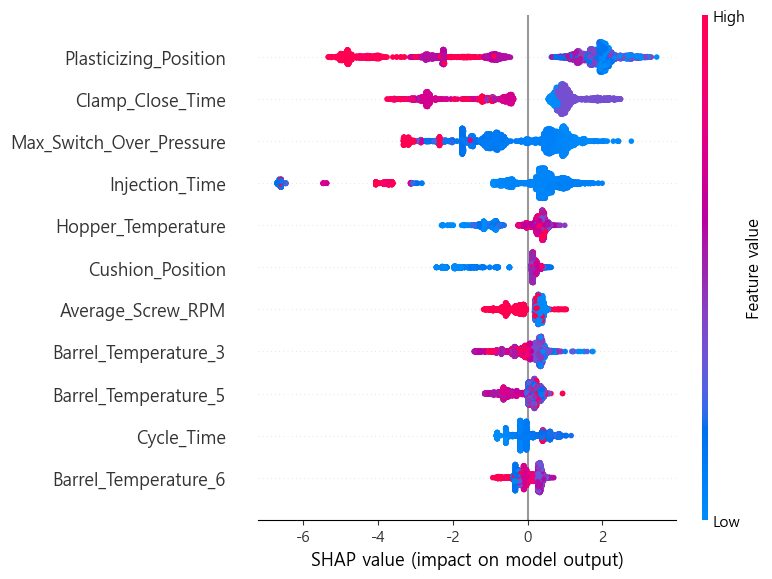

                     Feature  Mean_Absolute_SHAP
4      Plasticizing_Position            2.320987
2           Clamp_Close_Time            1.289490
6   Max_Switch_Over_Pressure            1.100621
0             Injection_Time            1.064590
10        Hopper_Temperature            0.523079
3           Cushion_Position            0.381874
5          Average_Screw_RPM            0.358265
7       Barrel_Temperature_3            0.327683
8       Barrel_Temperature_5            0.319443
1                 Cycle_Time            0.273448
9       Barrel_Temperature_6            0.251663


In [19]:
import shap
explainer = shap.Explainer(model, X_train_scaled)
shap_values = explainer(X_train_scaled,  check_additivity=False)

# X_train_scaled를 DataFrame으로 변환
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# SHAP 요약 플롯 생성
shap.summary_plot(shap_values, X_train_scaled_df)

import numpy as np
import pandas as pd

# SHAP 값은 explainer 호출 후 shap_values 객체에 저장됩니다.
# 각 피처의 평균 절대 기여도를 계산합니다.
mean_abs_shap = np.mean(np.abs(shap_values.values), axis=0)

# DataFrame으로 정리하여 피처명과 함께 보기 좋게 구성합니다.
shap_importance_df = pd.DataFrame({
    'Feature': X_train_scaled_df.columns,
    'Mean_Absolute_SHAP': mean_abs_shap
})

# 평균 절대 SHAP 값 기준 내림차순 정렬
shap_importance_df.sort_values('Mean_Absolute_SHAP', ascending=False, inplace=True)
print(shap_importance_df)

C:\Users\Admin\anaconda3\envs\dg_env_dl\lib\site-packages\shap\plots\_waterfall.py:237: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  text_bbox = txt_obj.get_window_extent(renderer=renderer)
C:\Users\Admin\anaconda3\envs\dg_env_dl\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


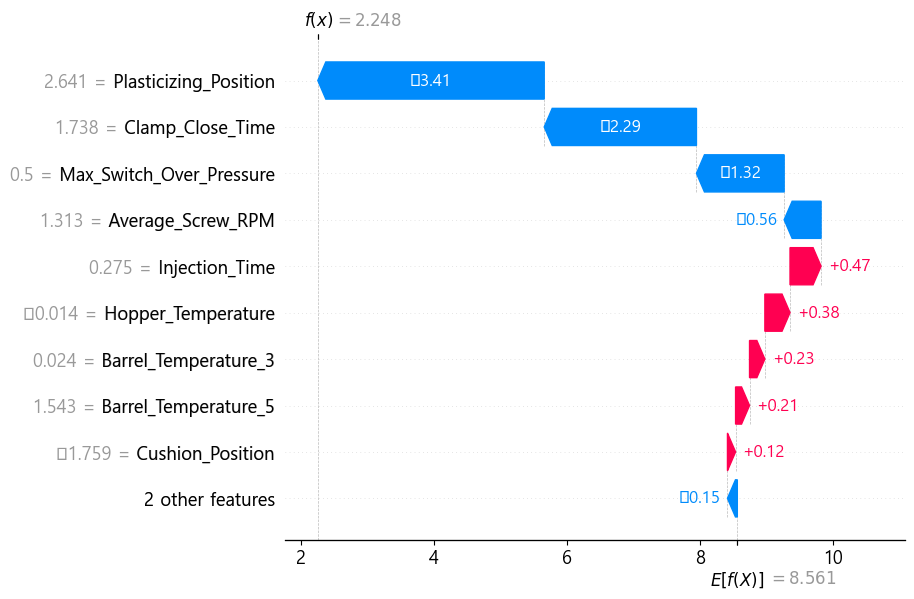

In [46]:
import shap
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False


# 정규화된 데이터를 DataFrame으로 변환 (원래 독립변수 명 사용)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_train.columns).reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)

# SHAP Explainer 생성 및 SHAP 값 계산 (additivity 검증 비활성화)
explainer = shap.Explainer(model, X_test_scaled_df)
shap_values = explainer(X_test_scaled_df, check_additivity=False)

# 하나의 샘플 선택 (예: 인덱스 0)
sample_idx = 1869

# 선택한 샘플에 대한 SHAP 값을 waterfall 플롯으로 시각화
shap.plots.waterfall(shap_values[sample_idx])


In [22]:
for i in range(len(y_test_reset)):
    if (y_test_reset[i] == 0):
        print(i)

22
213
233
352
520
780
785
1078
1104
1397
1463
1601
1638
1650
1866
1869


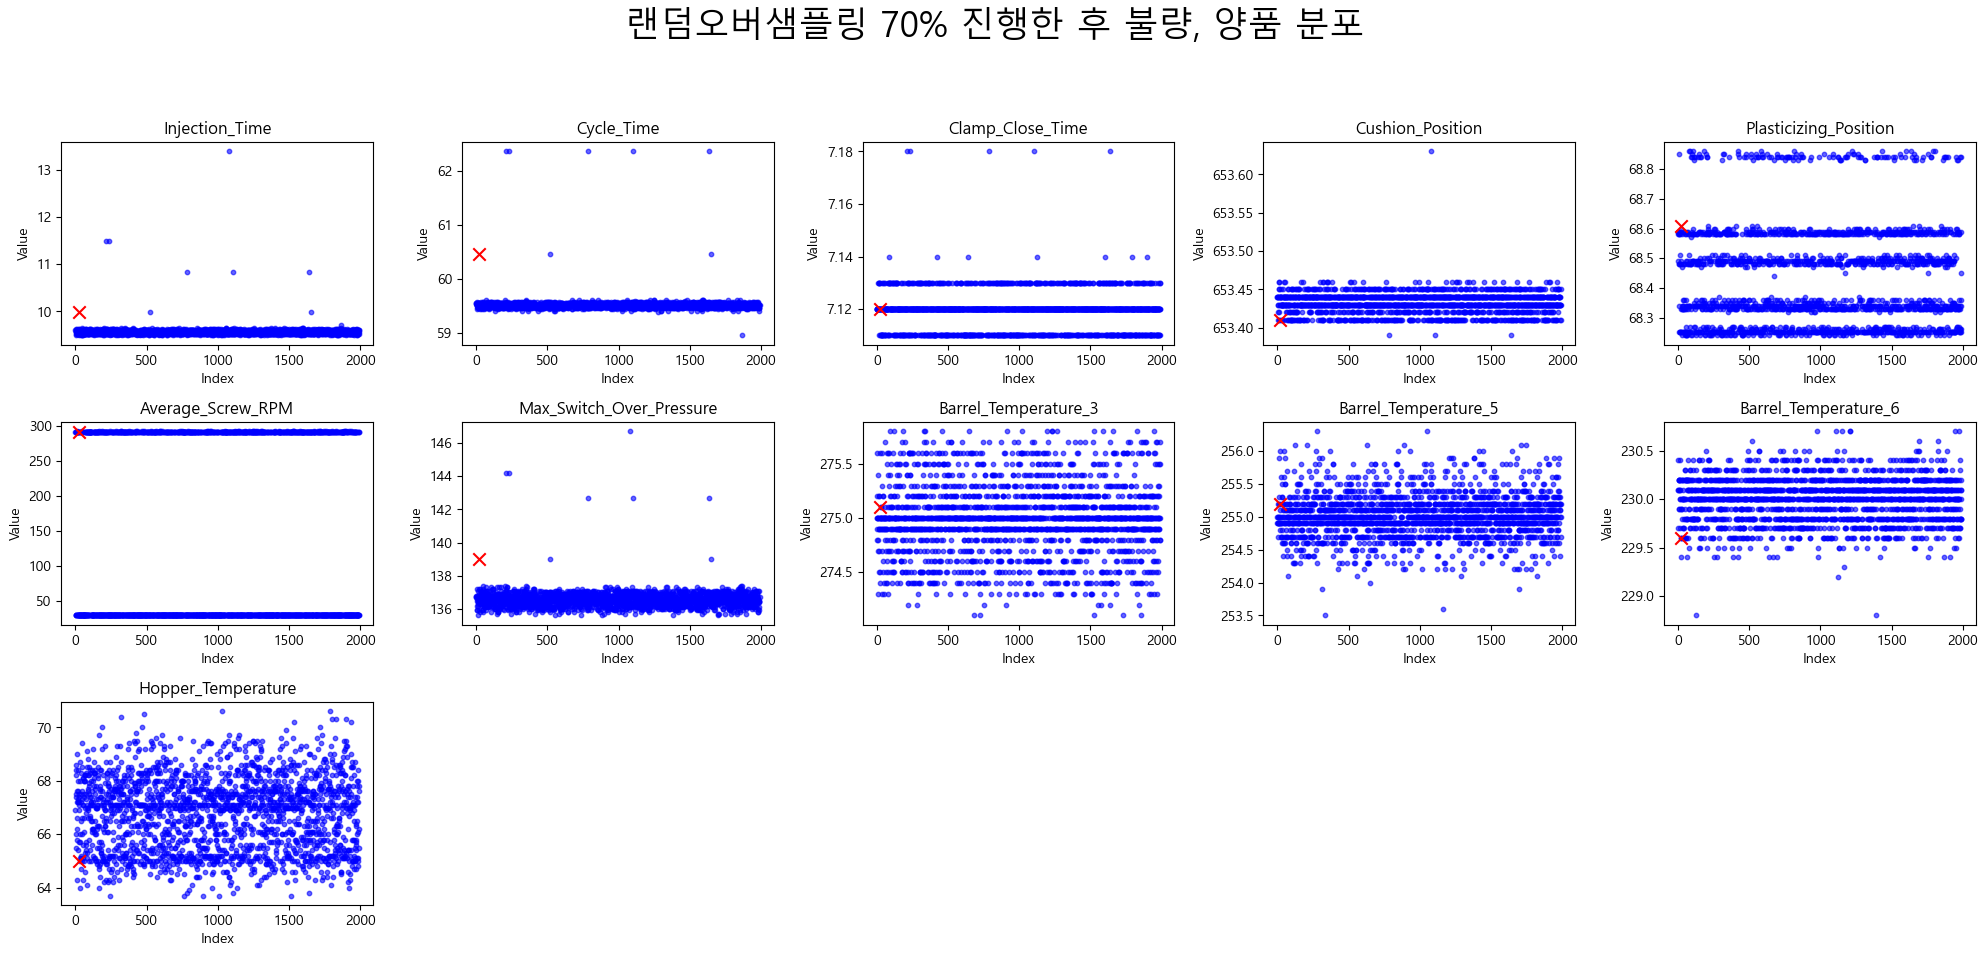

In [40]:
highlight_idx = 22  # 강조하고 싶은 인덱스로 수정

tmp_re = X_test.copy()
tmp_re["PassOrFail"] = y_test
tmp_re = tmp_re.reset_index(drop=True)

# 그래프 설정
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20, 15))
axes = axes.flatten()
fig.suptitle("랜덤오버샘플링 70% 진행한 후 불량, 양품 분포", fontsize=25)

# 독립 변수별 산점도 생성
for i, column in enumerate(X.columns):
    ax = axes[i]
    # highlight_idx가 아닌 나머지 데이터를 파란색으로 표시
    others = tmp_re.index != highlight_idx
    ax.scatter(tmp_re.index[others], tmp_re[column][others],
               label="Other", color="blue", alpha=0.6, s=10)
    
    # 특정 인덱스만 붉은색으로 표시 (highlight_idx가 존재할 경우)
    if highlight_idx in tmp_re.index:
        ax.scatter(tmp_re.index[tmp_re.index == highlight_idx],
                   tmp_re[column][tmp_re.index == highlight_idx],
                   label="Highlighted", color="red", alpha=1, s=80, marker='x')
    
    ax.set_title(column)
    ax.set_xlabel("Index")
    ax.set_ylabel("Value")

# 빈 그래프 제거
for j in range(len(X.columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("scatter_plot.png", dpi=300)  # 이미지 저장
plt.show()  # 화면 출력


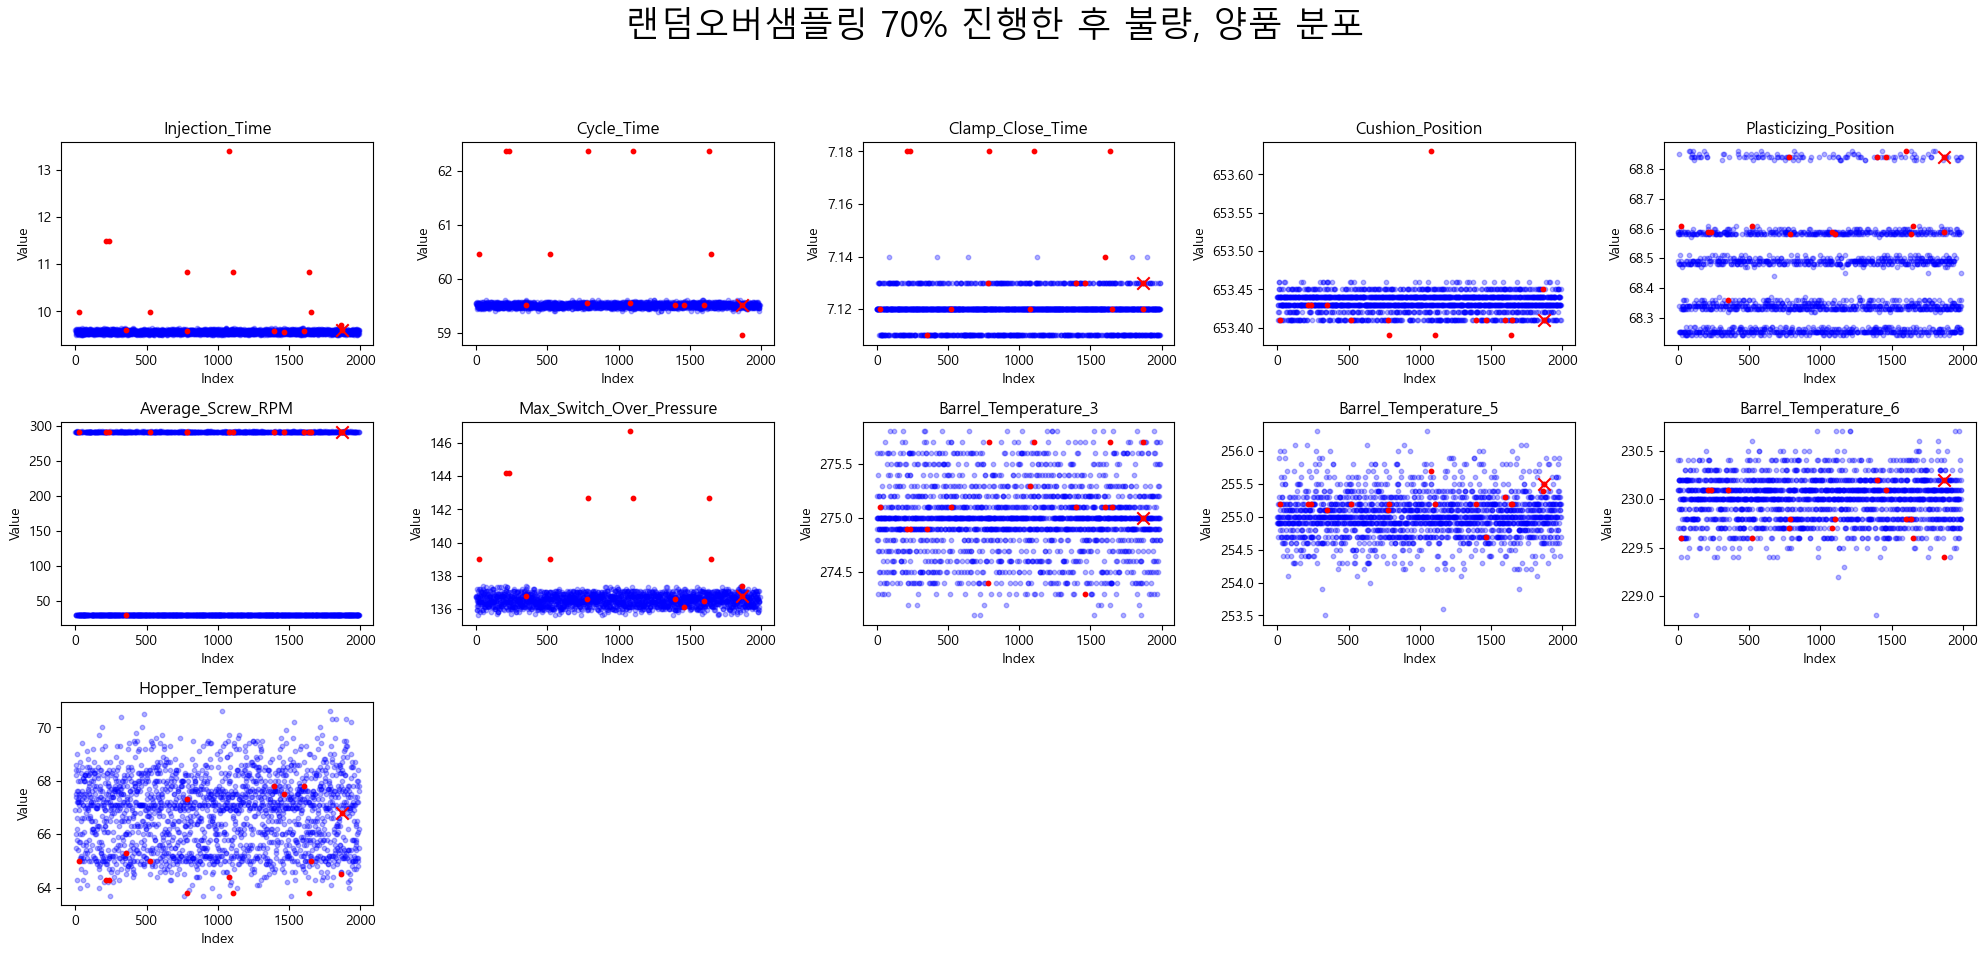

In [50]:
highlight_idx = 1869  # 강조하고 싶은 인덱스 (PassOrFail과 관계없이)
tmp_re = X_test.copy()
tmp_re["PassOrFail"] = y_test
tmp_re = tmp_re.reset_index(drop=True)

# 그래프 설정
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20, 15))
axes = axes.flatten()
fig.suptitle("랜덤오버샘플링 70% 진행한 후 불량, 양품 분포", fontsize=25)

# 독립 변수별 산점도 생성
for i, column in enumerate(X.columns):
    ax = axes[i]
    
    # PassOrFail == 1인 샘플만 파란색으로 플롯
    pass_filter = tmp_re["PassOrFail"] == 1
    ax.scatter(tmp_re.index[pass_filter], tmp_re[column][pass_filter],
               label="Pass", color="blue", alpha=0.3, s=10)

    # PassOrFail == 0인 샘플만 파란색으로 플롯
    pass_filter = tmp_re["PassOrFail"] == 0
    ax.scatter(tmp_re.index[pass_filter], tmp_re[column][pass_filter],
               label="Pass", color="red", alpha=1, s=10)
    
    # highlight_idx에 해당하는 샘플만 붉은색으로 강조 (PassOrFail 값과 관계없이)
    if highlight_idx in tmp_re.index:
        ax.scatter(tmp_re.index[tmp_re.index == highlight_idx],
                   tmp_re[column][tmp_re.index == highlight_idx],
                   label="Highlighted", color="red", alpha=1, s=80, marker='x')
    
    ax.set_title(column)
    ax.set_xlabel("Index")
    ax.set_ylabel("Value")

# 남는 하위 플롯 삭제
for j in range(len(X.columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("scatter_plot.png", dpi=300)
plt.show()


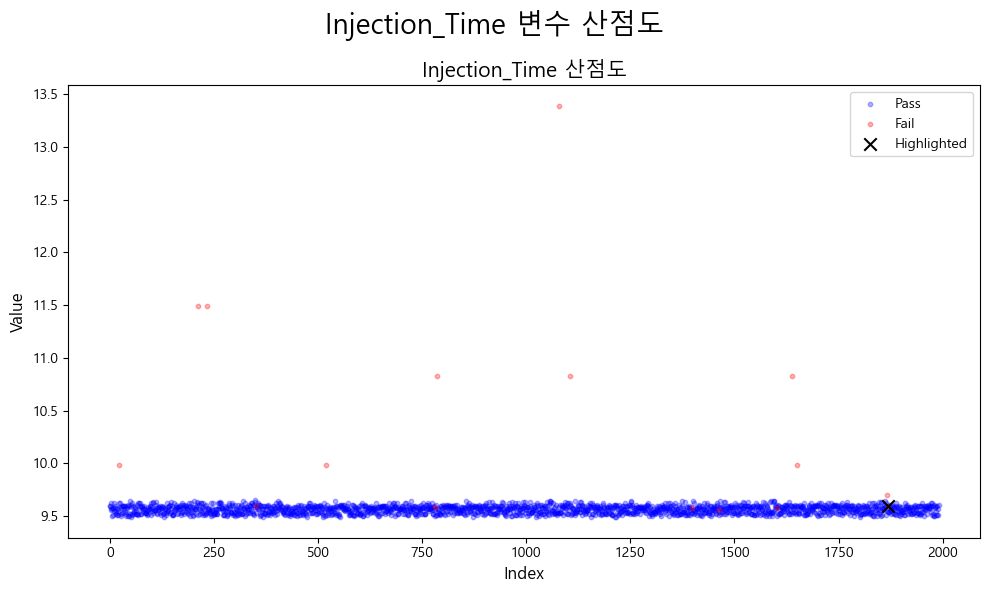

In [52]:
import matplotlib.pyplot as plt

highlight_idx = 1869  # 강조하고 싶은 인덱스 (PassOrFail과 관계없이)
tmp_re = X_test.copy()
tmp_re["PassOrFail"] = y_test
tmp_re = tmp_re.reset_index(drop=True)

# 그래프 설정
variable = "Injection_Time"  # 분석하고 싶은 변수명으로 변경하세요
fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle(f"{variable} 변수 산점도", fontsize=20)

# PassOrFail == 1인 샘플만 파란색으로 플롯
pass_filter = tmp_re["PassOrFail"] == 1
ax.scatter(tmp_re.index[pass_filter], tmp_re[variable][pass_filter],
           label="Pass", color="blue", alpha=0.3, s=10)

# PassOrFail == 0인 샘플만 빨간색으로 플롯
fail_filter = tmp_re["PassOrFail"] == 0
ax.scatter(tmp_re.index[fail_filter], tmp_re[variable][fail_filter],
           label="Fail", color="red", alpha=0.3, s=10)

# highlight_idx에 해당하는 샘플만 붉은색으로 강조 (PassOrFail 값과 관계없이)
if highlight_idx in tmp_re.index:
    ax.scatter(tmp_re.index[tmp_re.index == highlight_idx],
               tmp_re[variable][tmp_re.index == highlight_idx],
               label="Highlighted", color="black", alpha=1, s=80, marker='x')

# 그래프 제목 및 축 레이블 설정
ax.set_title(f"{variable} 산점도", fontsize=15)
ax.set_xlabel("Index", fontsize=12)
ax.set_ylabel("Value", fontsize=12)
ax.legend()

# 그래프 저장 및 출력
plt.tight_layout()
plt.savefig(f"{variable}_scatter_plot.png", dpi=300)
plt.show()


In [63]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 데이터프레임 생성 (예시)
# df = pd.read_csv('your_data.csv')  # 본인의 데이터셋을 불러오세요.

# PassOrFail 컬럼은 종속변수로 사용되므로 제외하고 독립변수만 선택
X = cn7.drop(columns=['PassOrFail'])

# VIF 계산 함수 정의
def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

# VIF 계산
vif_result = calculate_vif(X)

# 결과 출력
print(vif_result)


                     Feature           VIF
0             Injection_Time  3.794901e+06
1               Filling_Time  8.224260e+05
2          Plasticizing_Time  5.253933e+04
3                 Cycle_Time  8.139310e+05
4           Clamp_Close_Time  2.709581e+06
5           Cushion_Position  1.322664e+07
6      Plasticizing_Position  1.612755e+06
7        Max_Injection_Speed  1.064956e+05
8              Max_Screw_RPM  6.950554e+04
9          Average_Screw_RPM  1.327182e+01
10    Max_Injection_Pressure  3.837493e+06
11  Max_Switch_Over_Pressure  4.516069e+05
12         Max_Back_Pressure  9.640586e+04
13     Average_Back_Pressure  3.300749e+05
14      Barrel_Temperature_1  4.418054e+05
15      Barrel_Temperature_2  5.797767e+05
16      Barrel_Temperature_3  8.123719e+05
17      Barrel_Temperature_4  1.376131e+05
18      Barrel_Temperature_5  6.486211e+05
19      Barrel_Temperature_6  1.131511e+06
20        Hopper_Temperature  1.172465e+04
21        Mold_Temperature_3  1.704241e+04
22        M

In [61]:
pip install statsmodels

   ---------------------------------------- 0.0/9.9 MB ? eta -:--:--
   --------------- ------------------------ 3.9/9.9 MB 23.5 MB/s eta 0:00:01
   ----------------------------------- ---- 8.7/9.9 MB 23.4 MB/s eta 0:00:01
   ---------------------------------------- 9.9/9.9 MB 21.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
